
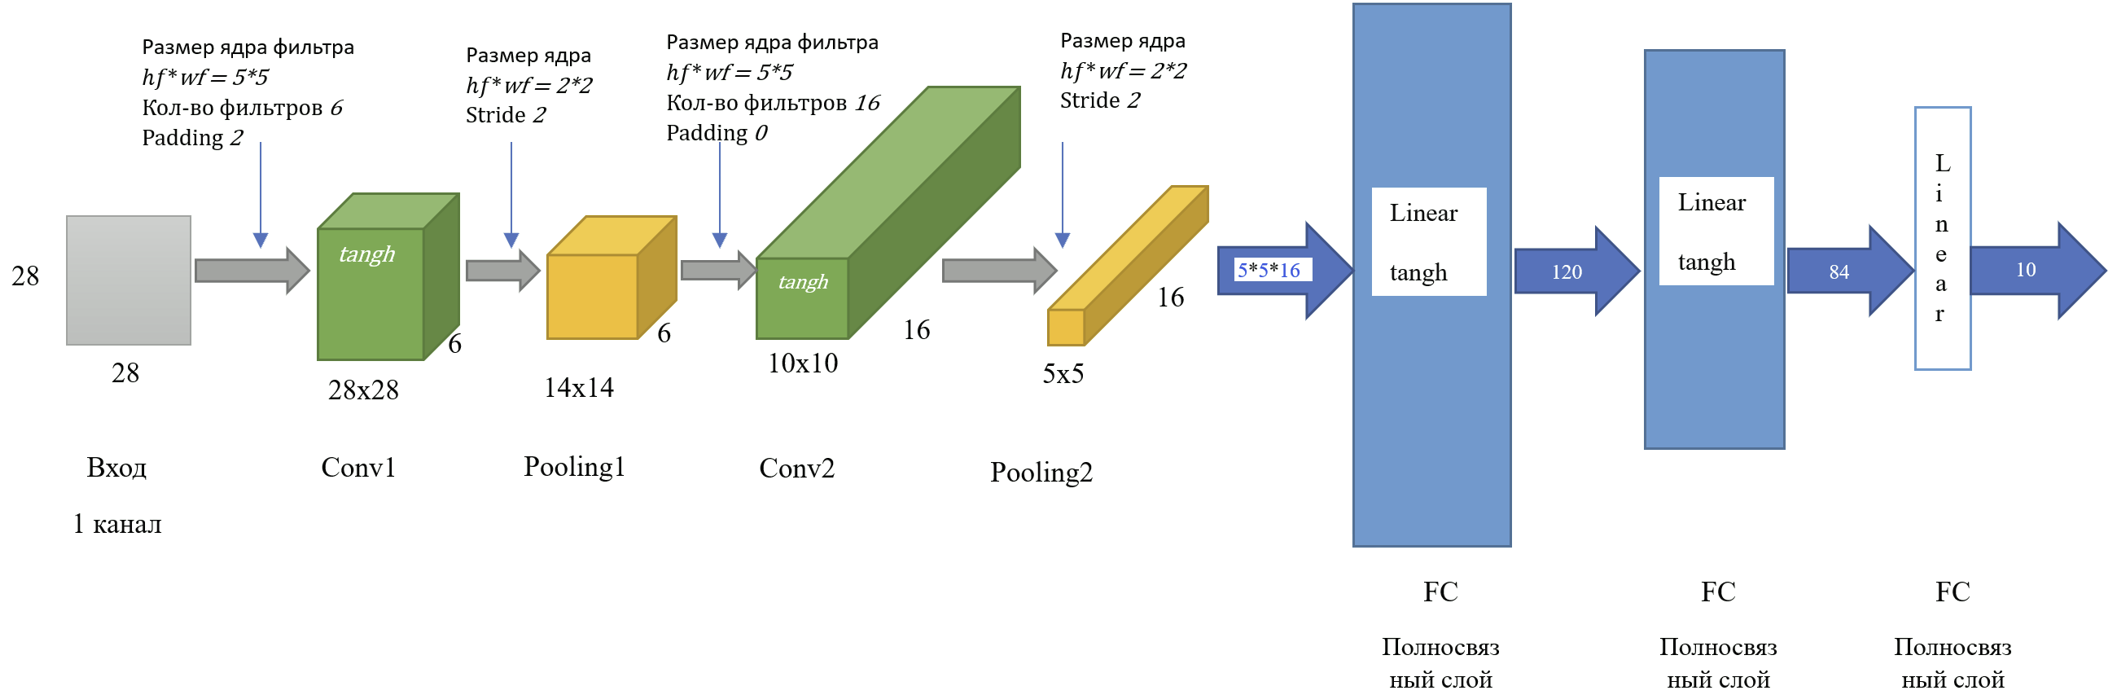


In [1]:
import torch
import random
import matplotlib.pyplot as plt
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [2]:
import os
os.environ['CUDA_LAUNCH_BLOCKING']='1'
os.environ['TORCH_USE_CUDA_DSA']='1'

In [3]:
import torchvision.datasets

In [5]:
from google.colab import drive
drive.mount('/content/MyDrive/')

Mounted at /content/MyDrive/


In [6]:
# лепим функцию для предварительного преобразования данных
transform = torchvision.transforms.Compose([
        torchvision.transforms.Resize((28, 28)),    # из 32x32 сделаем 28x28
        torchvision.transforms.ToTensor(),          # сразу в тензор
        torchvision.transforms.Grayscale(num_output_channels=1),  # из 3 каналов сделаем 1
])

In [10]:
# (я уже абсолютно понятия не имею, кто какой датасет здесь взял)
# загружаем датасет SVHN в трейн и тест
train = torchvision.datasets.SVHN(
    root='/SVHN',
    download=True,
    transform=transform,
    split='train')
test = torchvision.datasets.SVHN(
    root='/SVHN',
    download=True,
    transform=transform,
    split='test')


100%|██████████| 182M/182M [00:11<00:00, 15.6MB/s]


100%|██████████| 64.3M/64.3M [00:07<00:00, 8.40MB/s]


In [11]:
# загрузчики данных
from torch.utils.data import DataLoader
train_loader = DataLoader(dataset=train)
test_loader = DataLoader(dataset=test)

In [12]:
# фу-я для преобразования тензора обратно в PIL
back_to_image = lambda image: torchvision.transforms.ToPILImage()((image*255).byte())#.convert("RGB")

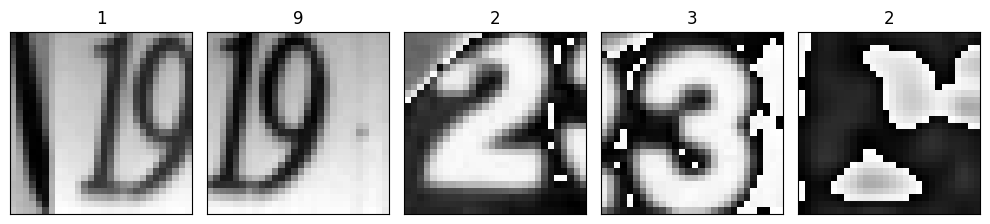

In [13]:
# отобразим несколько картинок
fig, axs = plt.subplots(ncols=5, figsize=(10, 4))

for i, ax in enumerate(axs):
  ax.set_title(train[i][1])
  ax.imshow(back_to_image(train[i][0]), cmap='grey')
  ax.set_xticks([])
  ax.set_yticks([])

plt.tight_layout()

In [14]:
X_list=[]
y_list=[]

for image, label in train_loader:
  X_list.append(image)
  y_list.append(label)

X_train = torch.cat(X_list)
y_train = torch.cat(y_list)

In [15]:
X_list.clear()
y_list.clear()

for image, label in test_loader:
  X_list.append(image)
  y_list.append(label)

X_test = torch.cat(X_list)
y_test = torch.cat(y_list)

In [16]:
# сколько здесь вообще классов
y_train.unique()

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [17]:
class LeNet5(torch.nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 6, 5, padding=2)
        self.act1  = torch.nn.Tanh()
        self.pool1 = torch.nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv2 = torch.nn.Conv2d(6, 16, 5, padding=0)
        self.act2  = torch.nn.Tanh()
        self.pool2 = torch.nn.AvgPool2d(kernel_size=2, stride=2)
        self.fc1   = torch.nn.Linear(5 * 5 * 16, 120)
        self.act3  = torch.nn.Tanh()
        self.fc2   = torch.nn.Linear(120, 84)
        self.act4  = torch.nn.Tanh()
        self.fc3   = torch.nn.Linear(84, 10)

    # наша самая главная функция. Определяем, что и в каком порядке будет вызываться
    def forward(self, x):
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))
        x = self.fc1(x)
        x = self.act3(x)
        x = self.fc2(x)
        x = self.act4(x)
        x = self.fc3(x)
        return x

# переменная - наша нейронка
lenet5 = LeNet5()

In [19]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
lenet5 = lenet5.to(device)

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [22]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lenet5.parameters(), lr=1.0e-3)

In [23]:
batch_size = 100

test_accuracy_history = []
test_loss_history = []
train_loss_history = []

X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(14):
    order = np.random.permutation(len(X_train))
    for start_index in range(0, len(X_train), batch_size):
        # обязательно обнуляем градиенты
        optimizer.zero_grad()
        # берем пачку параметров
        batch_indexes = order[start_index:start_index+batch_size]
        X_batch = X_train[batch_indexes].to(device)
        y_batch = y_train[batch_indexes].to(device)
        # делаем предсказание
        preds = lenet5.forward(X_batch)
        # считаем лосс значение
        loss_value = loss(preds, y_batch)
        # берем градиенты
        loss_value.backward()
        # и пусть оптимайзер все оптимизирует
        optimizer.step()

    # смотрим, что он тут нам напредсказывал, не забывая вовремя отправлять на cpu
    train_loss_history.append(loss_value.data.cpu())

    test_preds = lenet5.forward(X_test)
    test_loss_history.append(loss(test_preds, y_test).data.cpu())

    accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().data.cpu()
    test_accuracy_history.append(accuracy)

    print(f"epoch{epoch} - accuracy test {accuracy} ")

epoch0 - accuracy test 0.7281807065010071 
epoch1 - accuracy test 0.8031653165817261 
epoch2 - accuracy test 0.8261754512786865 
epoch3 - accuracy test 0.8377381563186646 
epoch4 - accuracy test 0.8421173691749573 
epoch5 - accuracy test 0.8485325574874878 
epoch6 - accuracy test 0.8471880555152893 
epoch7 - accuracy test 0.8538337349891663 
epoch8 - accuracy test 0.8549477458000183 
epoch9 - accuracy test 0.8543715476989746 
epoch10 - accuracy test 0.8545635938644409 
epoch11 - accuracy test 0.85440993309021 
epoch12 - accuracy test 0.8526428937911987 
epoch13 - accuracy test 0.8577520251274109 


Это не я глупая, а прошлый датасет был какой-то неправильный...

<ipython-input-24-fd538a322c0e>:3: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter1d


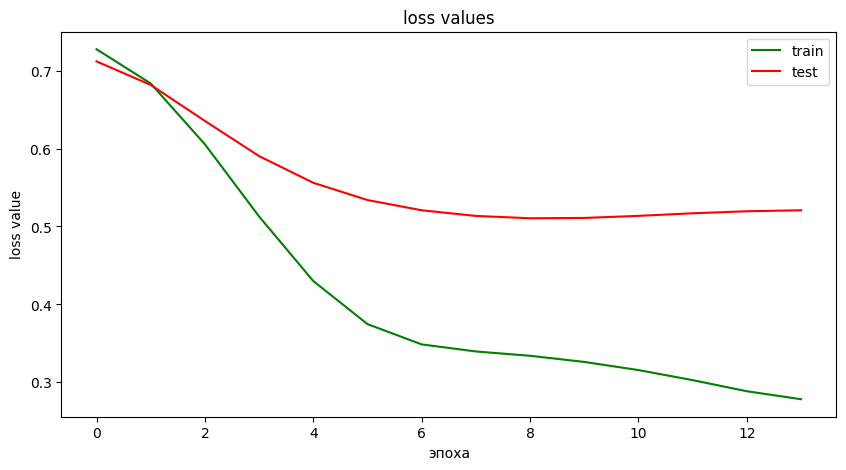

In [24]:
# строим графики - функции потерь

from scipy.ndimage.filters import gaussian_filter1d
fig = plt.figure(figsize=(10,5))

ax = fig.add_subplot(111)
ax.set(title = 'loss values',
       xlabel = 'эпоха',
       ylabel = 'loss value')
train_loss_smoothed = gaussian_filter1d(train_loss_history, sigma=2)
ax.plot(train_loss_smoothed, color='green',  label='train')

test_loss_smoothed = gaussian_filter1d(test_loss_history, sigma=2)
ax.plot(test_loss_smoothed, color='red',  label='test')
ax.legend()
plt.show()



<ipython-input-25-2c6bb4c2f673>:1: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter1d


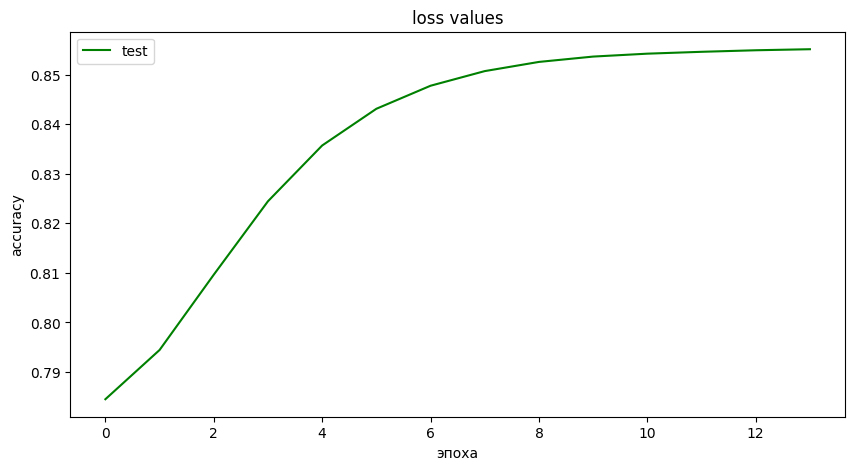

In [25]:
from scipy.ndimage.filters import gaussian_filter1d
fig = plt.figure(figsize=(10,5))

ax = fig.add_subplot(111)
ax.set(title = 'loss values',
       xlabel = 'эпоха',
       ylabel = 'accuracy')
test_accuracy_smoothed = gaussian_filter1d(test_accuracy_history, sigma=2)
ax.plot(test_accuracy_smoothed, color='green',  label='test')

ax.legend()
plt.show()

In [43]:
# сохраняем произвольную картинку в файл
timg = X_train[103]
torch.save(timg,'tensor.pt')

torch.Size([1, 28, 28])

In [44]:
!pip install dill

# сохраняем модель в файл
import dill
with open("lolz.dill", "wb") as dill_file:
    dill.dump(lenet5, dill_file)

In [37]:
# достаем обратно из файла
test_data = torch.load('tensor.pt')

<ipython-input-37-e695c8f86acd>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_data = torch.load('tensor.pt')


In [38]:
np.shape(test_data)

torch.Size([1, 28, 28])

In [31]:
file = open("lolz.dill", "rb")
my_model = dill.load(file)
file.close()

In [32]:
type(my_model)

__main__.LeNet5

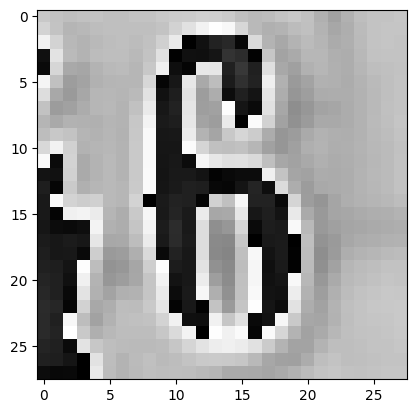

In [47]:
# посмотрим че там
plt.imshow(back_to_image(test_data), cmap='grey')

In [46]:
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [48]:
my_model.to(dev)

In [53]:
td = test_data.unsqueeze(1).float()
np.shape(td)

torch.Size([1, 1, 28, 28])

In [54]:
td = td.to(dev)

In [56]:
# попоробуем предсказать
preds = my_model.forward(td)
print(preds)

tensor([[-0.0704, -3.0345, -4.6445, -0.1077, -2.0756,  0.6626, 12.0133, -3.9614,
          4.9947, -4.9470]], grad_fn=<AddmmBackward0>)


In [57]:
prediction = np.argmax(preds.to('cpu').detach().numpy(),axis=1)

In [58]:
# ура-ура!!!
print(prediction)

[6]
